In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)

In [4]:
task_name = 'CCLE_topotecan_average' #'CCLE_topotecan_average CCLE_nutlin_3_average credit_g_average csi_pecarn_average
task = "regression" #"classification" #"regression"
baseline = False
# ablation_directory = f'./results/mdi_local.real_data_{task}/{task_name}/varying_sample_row_n'
#ablation_directory = f'./results/mdi_local.synthetic_data_linear/{task_name}/varying_heritability_n'
ablation_directory = f'./results/mdi_local.real_data_{task}_{task_name}/{task_name}_keep/varying_sample_row_n'
folder_names = [folder for folder in os.listdir(ablation_directory) if os.path.isdir(os.path.join(ablation_directory, folder))]
experiments_seeds = []
for folder_name in folder_names:
    experiments_seeds.append(int(folder_name[4:]))
combined_df = pd.DataFrame()
for seed in experiments_seeds:
    df = pd.read_csv(os.path.join(ablation_directory, f"seed{seed}/results.csv"))
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# rf_plus_directory = f'/scratch/users/zhongyuan_liang/saved_models/{task_name}'
# combined_df_rf_plus = pd.DataFrame()
# for file in os.listdir(rf_plus_directory):
#     if file.endswith(".csv"):
#         df = pd.read_csv(os.path.join(rf_plus_directory, file))
#         combined_df_rf_plus = pd.concat([combined_df_rf_plus, df], ignore_index=True)

In [5]:
combined_df.head()

,sample_row_n,sample_row_n_name,rep,n_estimators,min_samples_leaf,max_features,random_state,model,fi,train_size,train_subset_size,test_size,test_subset_size,num_features,data_split_seed,num_features_masked,sample_train_0,sample_train_1,sample_train_2,sample_train_3,sample_train_4,sample_train_5,sample_train_6,sample_train_7,sample_train_8,sample_train_9,sample_train_10,sample_train_11,sample_train_12,sample_train_13,sample_train_14,sample_train_15,sample_train_16,sample_train_17,sample_train_18,sample_train_19,sample_train_20,sample_train_21,sample_train_22,sample_train_23,sample_train_24,sample_train_25,sample_train_26,sample_train_27,sample_train_28,sample_train_29,sample_train_30,sample_train_31,sample_train_32,sample_train_33,sample_train_34,sample_train_35,sample_train_36,sample_train_37,sample_train_38,sample_train_39,sample_train_40,sample_train_41,sample_train_42,sample_train_43,sample_train_44,sample_train_45,sample_train_46,sample_train_47,sample_train_48,sample_train_49,sample_train_50,sample_train_51,sample_train_52,sample_train_53,sample_train_54,sample_train_55,sample_train_56,sample_train_57,sample_train_58,sample_train_59,sample_train_60,sample_train_61,sample_train_62,sample_train_63,sample_train_64,sample_train_65,sample_train_66,sample_train_67,sample_train_68,sample_train_69,sample_train_70,sample_train_71,sample_train_72,sample_train_73,sample_train_74,sample_train_75,sample_train_76,sample_train_77,sample_train_78,sample_train_79,sample_train_80,sample_train_81,sample_train_82,sample_train_83,sample_train_84,sample_train_85,sample_train_86,sample_train_87,sample_train_88,sample_train_89,sample_train_90,sample_train_91,sample_train_92,sample_train_93,sample_train_94,sample_train_95,sample_train_96,sample_train_97,sample_train_98,sample_train_99,sample_test_0,sample_test_1,sample_test_2,sample_test_3,sample_test_4,sample_test_5,sample_test_6,sample_test_7,sample_test_8,sample_test_9,sample_test_10,sample_test_11,sample_test_12,sample_test_13,sample_test_14,sample_test_15,sample_test_16,sample_test_17,sample_test_18,sample_test_19,sample_test_20,sample_test_21,sample_test_22,sample_test_23,sample_test_24,sample_test_25,sample_test_26,sample_test_27,sample_test_28,sample_test_29,sample_test_30,sample_test_31,sample_test_32,sample_test_33,sample_test_34,sample_test_35,sample_test_36,sample_test_37,sample_test_38,sample_test_39,sample_test_40,sample_test_41,sample_test_42,sample_test_43,sample_test_44,sample_test_45,sample_test_46,sample_test_47,sample_test_48,sample_test_49,sample_test_50,sample_test_51,sample_test_52,sample_test_53,sample_test_54,sample_test_55,sample_test_56,sample_test_57,sample_test_58,sample_test_59,sample_test_60,sample_test_61,sample_test_62,sample_test_63,sample_test_64,sample_test_65,sample_test_66,sample_test_67,sample_test_68,sample_test_69,sample_test_70,sample_test_71,sample_test_72,sample_test_73,sample_test_74,sample_test_75,sample_test_76,sample_test_77,sample_test_78,sample_test_79,sample_test_80,sample_test_81,sample_test_82,sample_test_83,sample_test_84,sample_test_85,sample_test_86,sample_test_87,sample_test_88,sample_test_89,sample_test_90,sample_test_91,sample_test_92,sample_test_93,sample_test_94,sample_test_95,sample_test_96,sample_test_97,sample_test_98,sample_test_99,load_model_time,fi_time_absolute,num_features_masked_0.05,RF_Regressor_MSE_after_ablation_0.05,RF_Regressor_R2_after_ablation_0.05,Linear_MSE_after_ablation_0.05,Linear_R2_after_ablation_0.05,XGB_Regressor_MSE_after_ablation_0.05,XGB_Regressor_R2_after_ablation_0.05,RF_Plus_Regressor_MSE_after_ablation_0.05,RF_Plus_Regressor_R2_after_ablation_0.05,num_features_masked_0.1,RF_Regressor_MSE_after_ablation_0.1,RF_Regressor_R2_after_ablation_0.1,Linear_MSE_after_ablation_0.1,Linear_R2_after_ablation_0.1,XGB_Regressor_MSE_after_ablation_0.1,XGB_Regressor_R2_after_ablation_0.1,RF_Plus_Regressor_MSE_after_ablation_0.1,RF_Plus_Regressor_R2_after_ablation_0.1,num_features_masked_0.25,RF_Regressor_MSE_after_ablation

### Summarise the Ablation Data

In [6]:
train_size = combined_df["train_size"].unique()[0]
test_size = combined_df["test_size"].unique()[0]
print(f"The training size is {train_size} and the test size is {test_size}")

The training size is 316 and the test size is 156


In [7]:
combined_df["fi"].unique()

array(['LIME_RF', 'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus',
       'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_error_metric',
       'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_l2_norm',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_error_metric',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_l2_norm', 'Random',
       'TreeSHAP_RF'], dtype=object)

### Plot the Ablation Data Performance

In [8]:
methods = ['LIME_RF', 'Local_MDI+_fit_on_OOB_RFPlus',
       'Local_MDI+_fit_on_OOB_RFPlus_l2_norm',
       'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus',
       'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_l2_norm',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_l2_norm',
       'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_error_metric',
       'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_error_metric',
        #'Random',
       'TreeSHAP_RF']
metrics = {"regression": ["MSE", "R2"], "classification": ["AUROC", "F1", "logloss"]} #"AUPRC",
ablation_models = {"regression": ["RF_Regressor", "Linear", "XGB_Regressor", "RF_Plus_Regressor"],
                   "classification": ["RF_Classifier","LogisticCV", "SVM", "XGBoost_Classifier", "RF_Plus_Classifier"]}
color_map = {
    'Kernel_SHAP_RF_plus': '#1f77b4',  # Blue
    'LIME_RF': '#8c564b',  # Brown
    'Local_MDI+_fit_on_OOB_RFPlus_l2_norm': '#ff7f0e',  # Orange
    'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_l2_norm': '#2ca02c',  # Green
    'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_l2_norm': '#9467bd',  # Purple
    'Local_MDI+_fit_on_OOB_RFPlus': '#ffbb78',  # Light Orange
    'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus': '#98df8a',  # Light Green
    'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus': '#c5b0d5',  # Light Purple
    'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_error_metric': '#d62728',  # Red
    'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_error_metric': '#bcbd22',  # Yellow
    'Random': '#7f7f7f',  # Gray
    'TreeSHAP_RF': '#e377c2',  # Pink
}

In [9]:
all_ratios = [0.05, 0.1, 0.25, 0.5, 0.9]
num_features_selected = []
for r in all_ratios:
    num_features_selected.append(combined_df[f"num_features_masked_{r}"].unique()[0])

#### Training Subset Data

In [10]:
combined_df

,sample_row_n,sample_row_n_name,rep,n_estimators,min_samples_leaf,max_features,random_state,model,fi,train_size,train_subset_size,test_size,test_subset_size,num_features,data_split_seed,num_features_masked,sample_train_0,sample_train_1,sample_train_2,sample_train_3,sample_train_4,sample_train_5,sample_train_6,sample_train_7,sample_train_8,sample_train_9,sample_train_10,sample_train_11,sample_train_12,sample_train_13,sample_train_14,sample_train_15,sample_train_16,sample_train_17,sample_train_18,sample_train_19,sample_train_20,sample_train_21,sample_train_22,sample_train_23,sample_train_24,sample_train_25,sample_train_26,sample_train_27,sample_train_28,sample_train_29,sample_train_30,sample_train_31,sample_train_32,sample_train_33,sample_train_34,sample_train_35,sample_train_36,sample_train_37,sample_train_38,sample_train_39,sample_train_40,sample_train_41,sample_train_42,sample_train_43,sample_train_44,sample_train_45,sample_train_46,sample_train_47,sample_train_48,sample_train_49,sample_train_50,sample_train_51,sample_train_52,sample_train_53,sample_train_54,sample_train_55,sample_train_56,sample_train_57,sample_train_58,sample_train_59,sample_train_60,sample_train_61,sample_train_62,sample_train_63,sample_train_64,sample_train_65,sample_train_66,sample_train_67,sample_train_68,sample_train_69,sample_train_70,sample_train_71,sample_train_72,sample_train_73,sample_train_74,sample_train_75,sample_train_76,sample_train_77,sample_train_78,sample_train_79,sample_train_80,sample_train_81,sample_train_82,sample_train_83,sample_train_84,sample_train_85,sample_train_86,sample_train_87,sample_train_88,sample_train_89,sample_train_90,sample_train_91,sample_train_92,sample_train_93,sample_train_94,sample_train_95,sample_train_96,sample_train_97,sample_train_98,sample_train_99,sample_test_0,sample_test_1,sample_test_2,sample_test_3,sample_test_4,sample_test_5,sample_test_6,sample_test_7,sample_test_8,sample_test_9,sample_test_10,sample_test_11,sample_test_12,sample_test_13,sample_test_14,sample_test_15,sample_test_16,sample_test_17,sample_test_18,sample_test_19,sample_test_20,sample_test_21,sample_test_22,sample_test_23,sample_test_24,sample_test_25,sample_test_26,sample_test_27,sample_test_28,sample_test_29,sample_test_30,sample_test_31,sample_test_32,sample_test_33,sample_test_34,sample_test_35,sample_test_36,sample_test_37,sample_test_38,sample_test_39,sample_test_40,sample_test_41,sample_test_42,sample_test_43,sample_test_44,sample_test_45,sample_test_46,sample_test_47,sample_test_48,sample_test_49,sample_test_50,sample_test_51,sample_test_52,sample_test_53,sample_test_54,sample_test_55,sample_test_56,sample_test_57,sample_test_58,sample_test_59,sample_test_60,sample_test_61,sample_test_62,sample_test_63,sample_test_64,sample_test_65,sample_test_66,sample_test_67,sample_test_68,sample_test_69,sample_test_70,sample_test_71,sample_test_72,sample_test_73,sample_test_74,sample_test_75,sample_test_76,sample_test_77,sample_test_78,sample_test_79,sample_test_80,sample_test_81,sample_test_82,sample_test_83,sample_test_84,sample_test_85,sample_test_86,sample_test_87,sample_test_88,sample_test_89,sample_test_90,sample_test_91,sample_test_92,sample_test_93,sample_test_94,sample_test_95,sample_test_96,sample_test_97,sample_test_98,sample_test_99,load_model_time,fi_time_absolute,num_features_masked_0.05,RF_Regressor_MSE_after_ablation_0.05,RF_Regressor_R2_after_ablation_0.05,Linear_MSE_after_ablation_0.05,Linear_R2_after_ablation_0.05,XGB_Regressor_MSE_after_ablation_0.05,XGB_Regressor_R2_after_ablation_0.05,RF_Plus_Regressor_MSE_after_ablation_0.05,RF_Plus_Regressor_R2_after_ablation_0.05,num_features_masked_0.1,RF_Regressor_MSE_after_ablation_0.1,RF_Regressor_R2_after_ablation_0.1,Linear_MSE_after_ablation_0.1,Linear_R2_after_ablation_0.1,XGB_Regressor_MSE_after_ablation_0.1,XGB_Regressor_R2_after_ablation_0.1,RF_Plus_Regressor_MSE_after_ablation_0.1,RF_Plus_Regressor_R2_after_ablation_0.1,num_features_masked_0.25,RF_Regressor_MSE_after_ablation

In [11]:
if task == "classification":
    fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
    for i, a_model in enumerate(ablation_models[task]):
        for j, metric in enumerate(metrics[task]):
            results = {}
            for m in methods:
                results[m] = []
            for m in methods:
                for k in all_ratios:
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+f"_{metric}_{k}_absolute"].mean())
            ax = axs[i, j] 
            for m in methods:
                color = color_map[m]
                if m in ["TreeSHAP_RF",  "LIME_RF", "Random"]:
                    ax.plot(all_ratios, results[m], label=m, linestyle='dashed', color=color)
                else:
                    ax.plot(all_ratios, results[m], label=m, color=color)
            ax.set(xlabel='Number of features selected', ylabel= f"{metric}",
                title=f'Ablation model = {a_model}')
            if i == 0 and j==0:
                ax.legend()

    plt.tight_layout()
    plt.savefig(f"./{task_name}_{task}.png")
    plt.show()

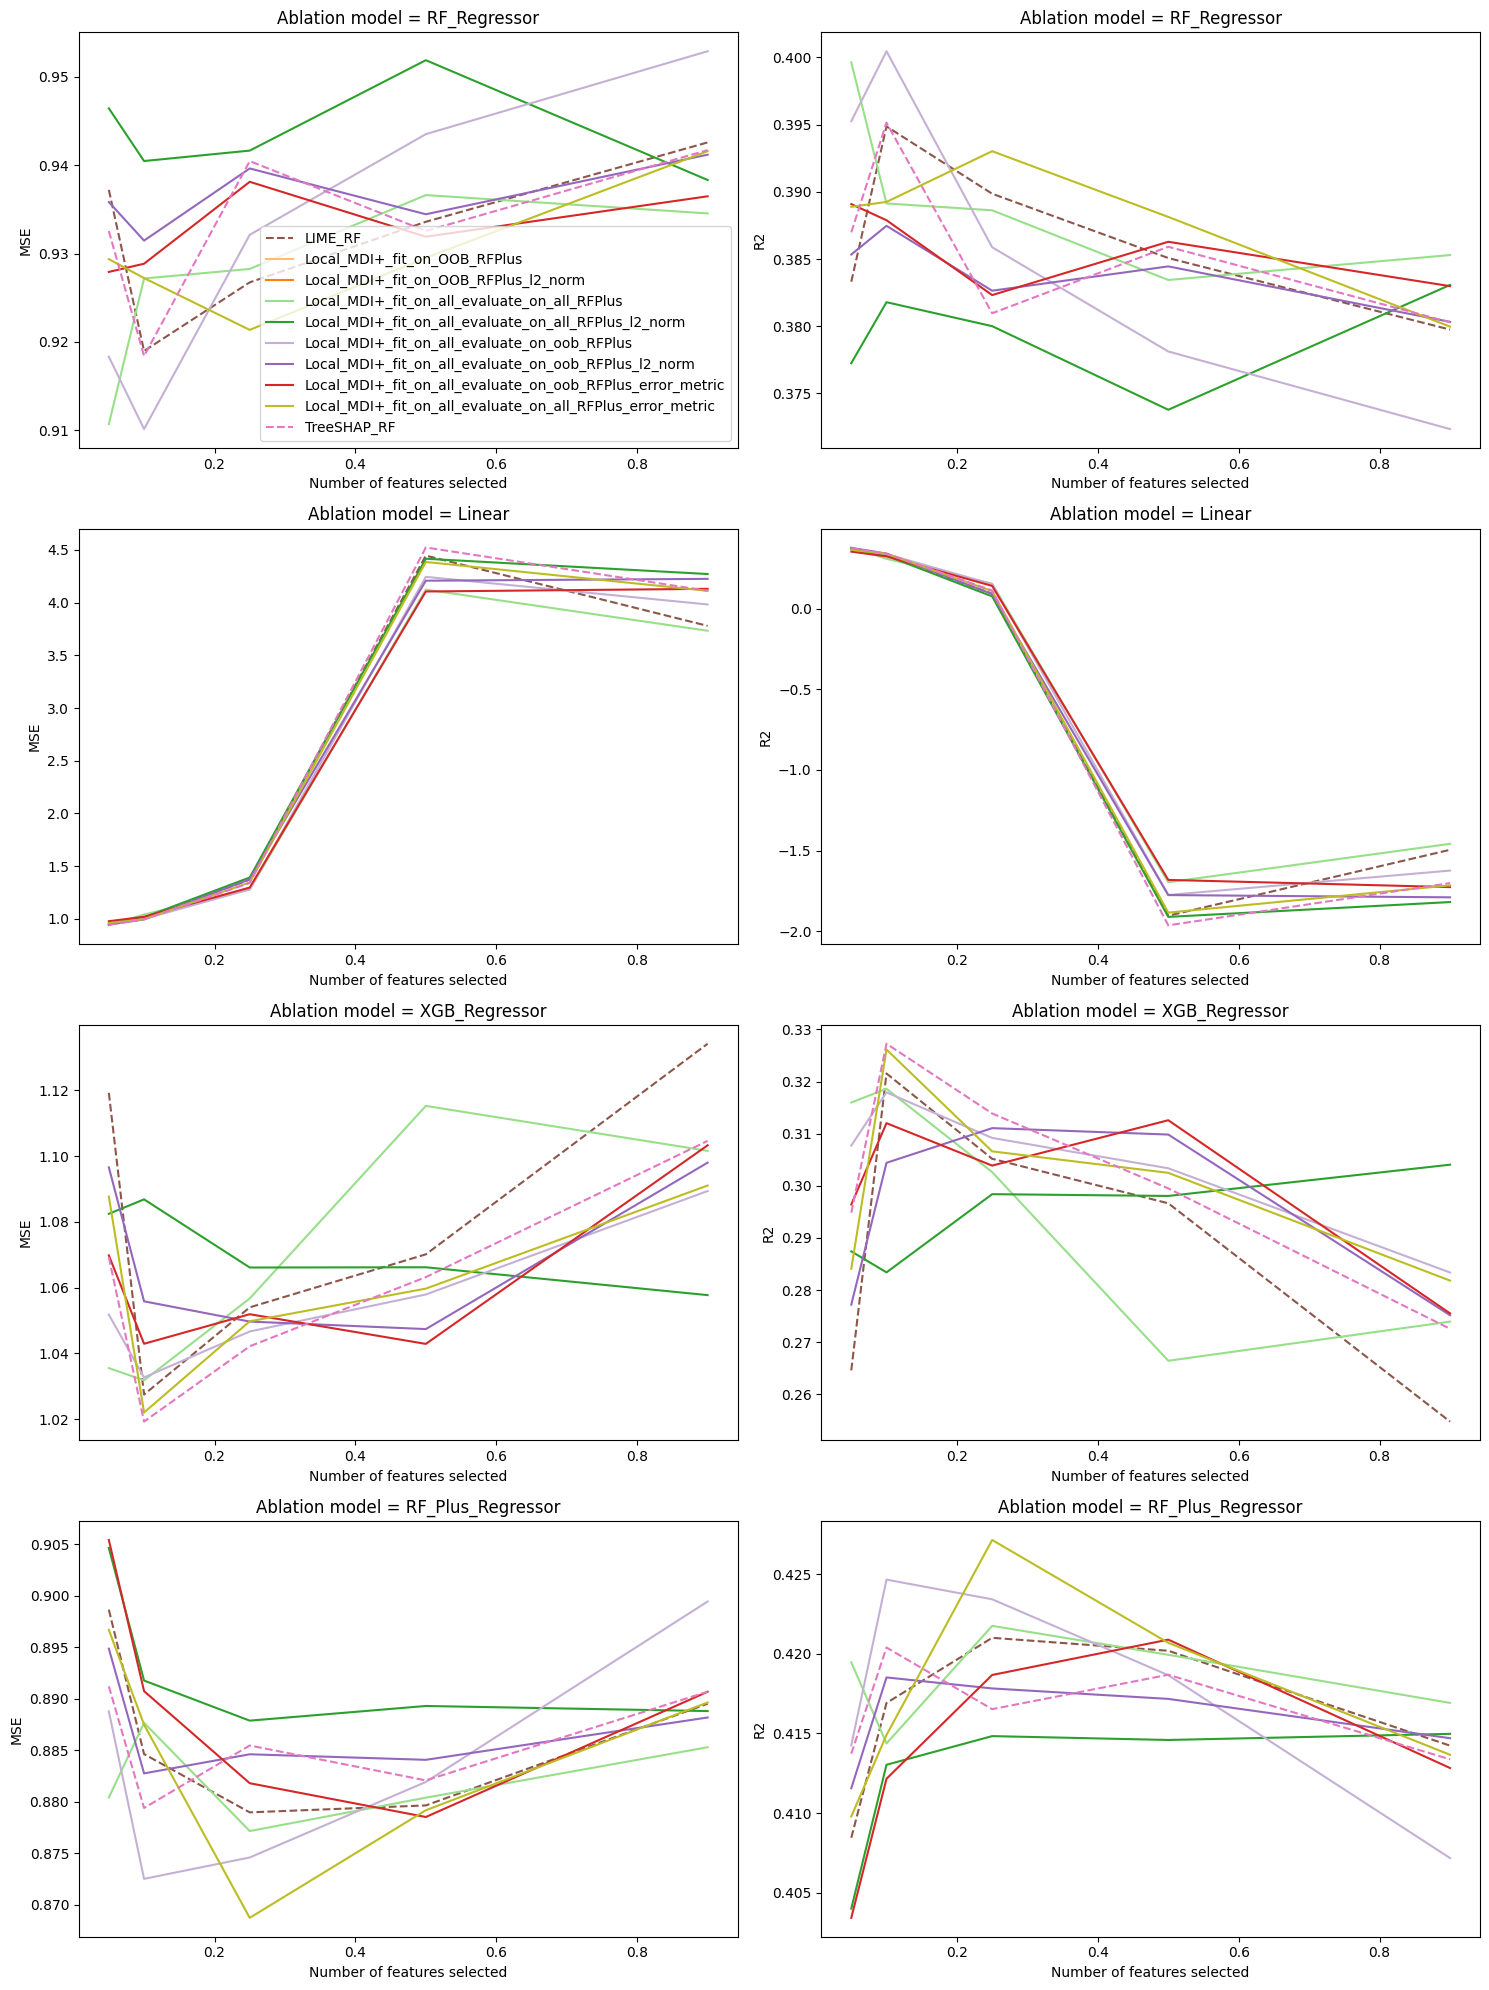

In [12]:
if task == "regression":
    fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
    for i, a_model in enumerate(ablation_models[task]):
        for j, metric in enumerate(metrics[task]):
            results = {}
            for m in methods:
                results[m] = []
            for m in methods:
                for k in all_ratios:
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+f"_{metric}_after_ablation_{k}"].mean())
            ax = axs[i, j] 
            for m in methods:
                color = color_map[m]
                if m in ["TreeSHAP_RF",  "LIME_RF", "Random"]:
                    ax.plot(all_ratios, results[m], label=m, linestyle='dashed', color=color)
                else:
                    ax.plot(all_ratios, results[m], label=m, color=color)
            ax.set(xlabel='Number of features selected', ylabel= f"{metric}",
                title=f'Ablation model = {a_model}')
            if i == 0 and j==0:
                ax.legend()

    plt.tight_layout()
    plt.savefig(f"./{task_name}_{task}.png")
    plt.show()

In [13]:
results

{'LIME_RF': [0.4084529933463201,
  0.41691246664508974,
  0.4210019100826092,
  0.42018859818720267,
  0.41423524527420397],
 'Local_MDI+_fit_on_OOB_RFPlus': [nan, nan, nan, nan, nan],
 'Local_MDI+_fit_on_OOB_RFPlus_l2_norm': [nan, nan, nan, nan, nan],
 'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus': [0.4194655754199465,
  0.4143716996516692,
  0.421751733857994,
  0.41993618164671087,
  0.41691683228343224],
 'Local_MDI+_fit_on_all_evaluate_on_all_RFPlus_l2_norm': [0.40401215814418384,
  0.4130347074565823,
  0.4148335157323484,
  0.4145912181583019,
  0.4149749229048849],
 'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus': [0.41425550609524164,
  0.42465313091511053,
  0.4234199514905326,
  0.4186545004201521,
  0.4071798796174875],
 'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_l2_norm': [0.4115642533622782,
  0.41851588552555397,
  0.4178245902912072,
  0.41716880288208374,
  0.4147021520585786],
 'Local_MDI+_fit_on_all_evaluate_on_oob_RFPlus_error_metric': [0.40343022944479906,
  0.4

NameError: name 'methods_train_subset' is not defined

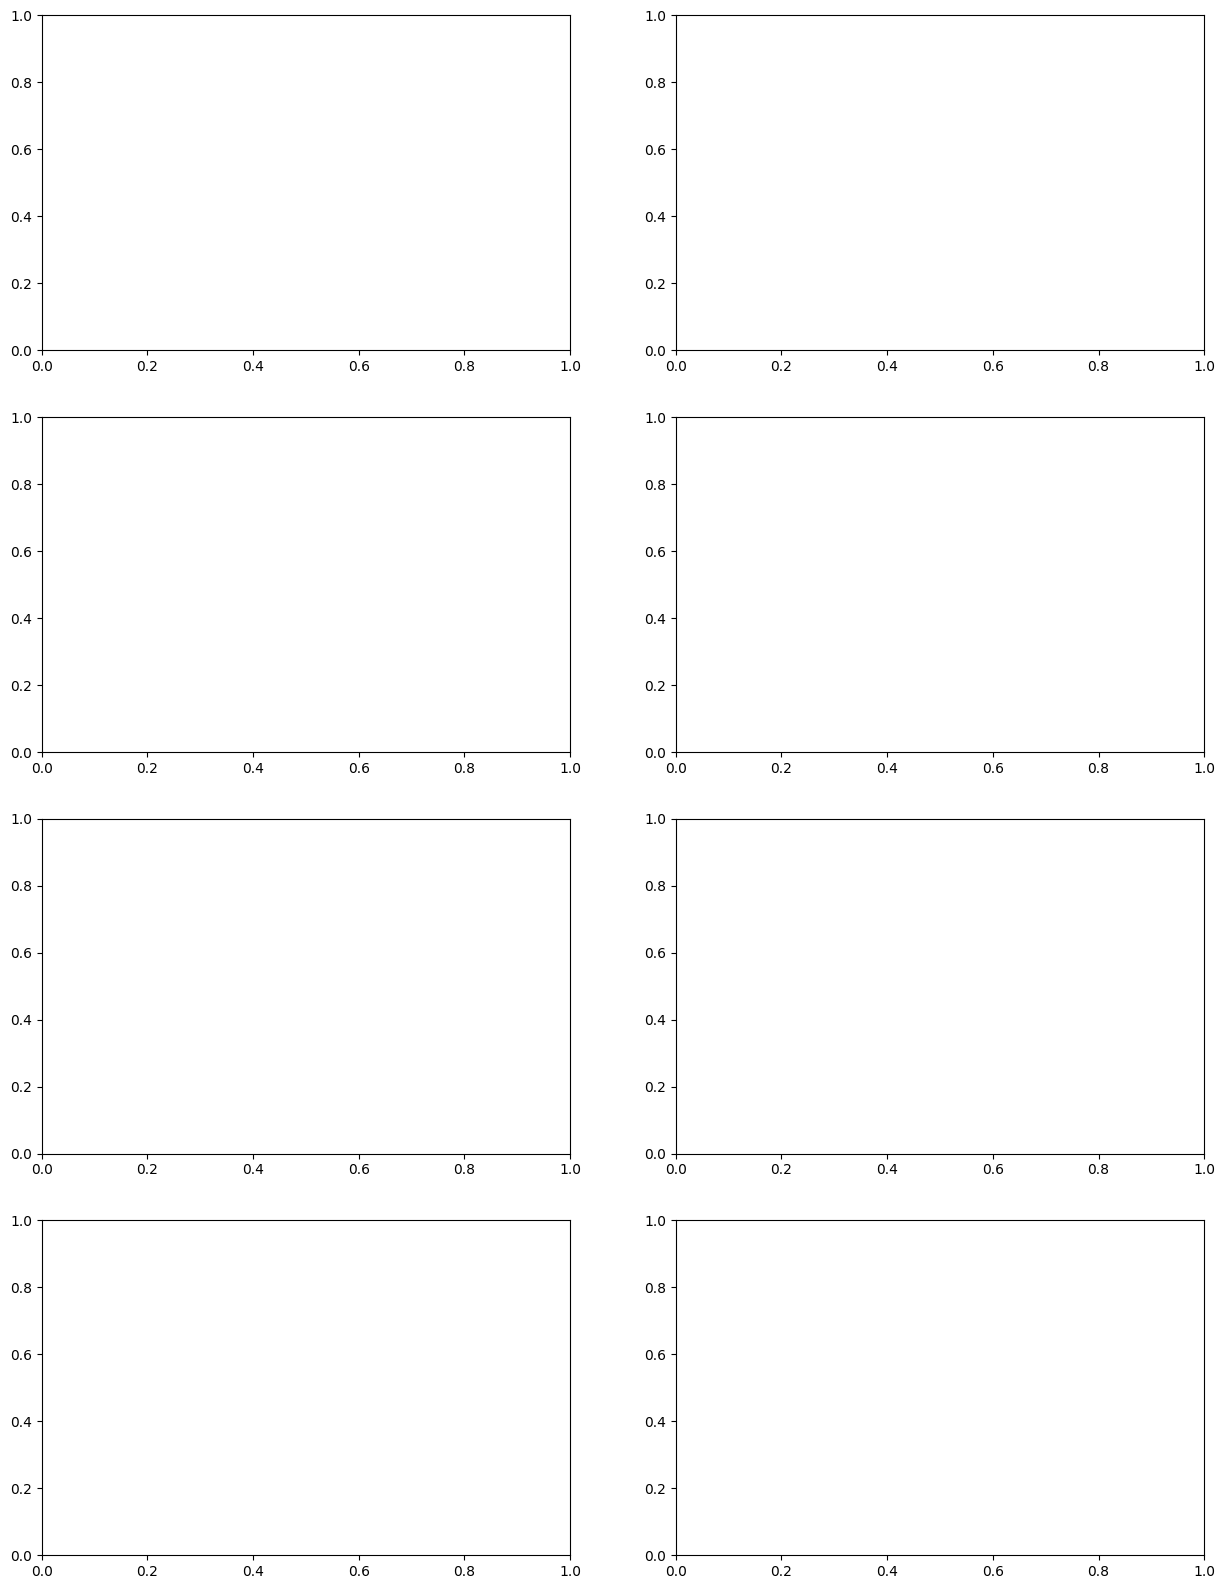

In [14]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            for k in range(num_features+1):
                results[m].append(combined_df[combined_df['fi'] == m][a_model+f"_test_subset_delta_{metric}_after_ablation_{k}_absolute"].mean())
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        ax.set(xlabel='Number of features ablated', ylabel= f"metric",
            title=f'Ablation model = {a_model}')
        if i == 0:
            ax.legend()

plt.tight_layout()
# plt.savefig(f"./{task_name}_{task}_test_subset_removal_absolute.png")
plt.show()

NameError: name 'methods_train_subset' is not defined

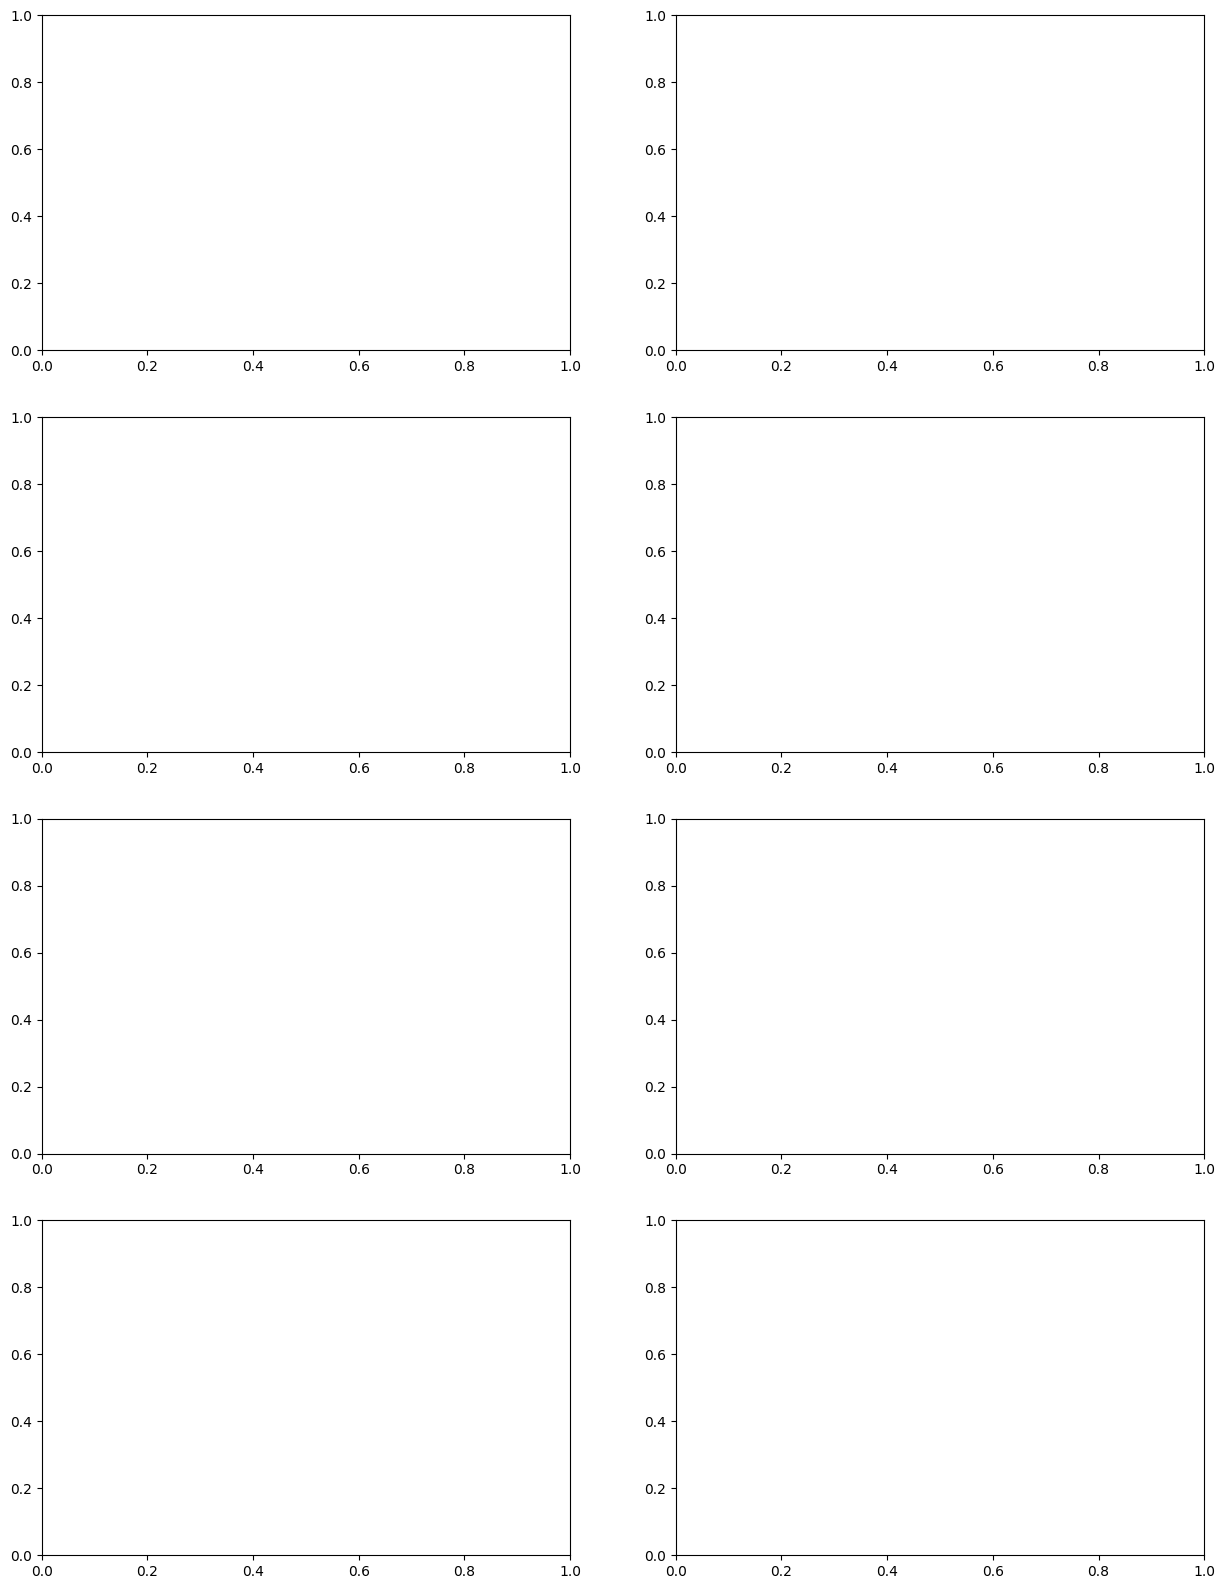

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            for k in range(num_features+1):
                results[m].append(combined_df[combined_df['fi'] == m][a_model+f"_test_delta_{metric}_after_ablation_{k}_absolute"].mean())
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        ax.set(xlabel='Number of features ablated', ylabel= f"metric",
            title=f'Ablation model = {a_model}')
        if i == 0:
            ax.legend()

plt.tight_layout()
# plt.savefig(f"./{task_name}_{task}_test_removal_absolute.png")
plt.show()

NameError: name 'methods_train_subset' is not defined

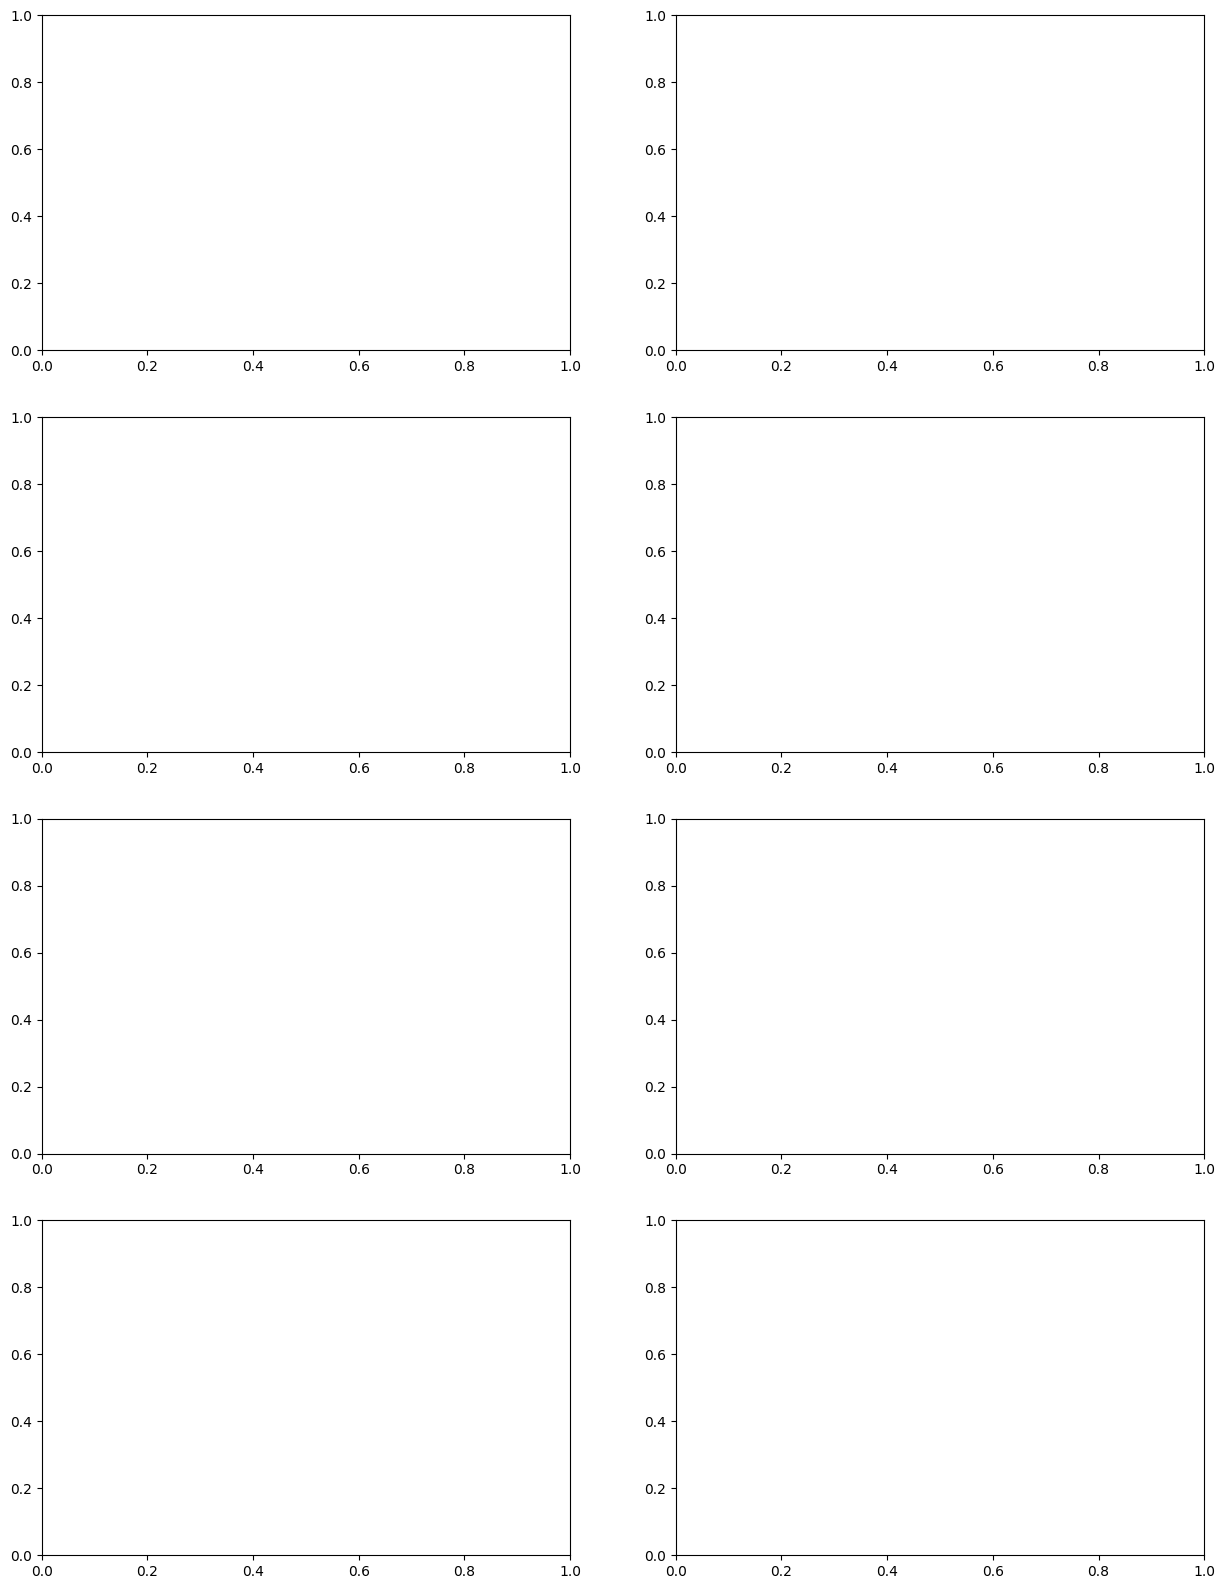

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_train_subset_delta_MSE_after_ablation_{k}_positive"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_train_subset_delta_MSE_after_ablation_{k}_negative"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

### Test subset

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_subset_delta_MSE_after_ablation_{k}_absolute"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
plt.savefig(f"./{task_name}_{task}_test_subset_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_subset_delta_MSE_after_ablation_{k}_positive"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_subset_delta_MSE_after_ablation_{k}_negative"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

### Test set

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_delta_MSE_after_ablation_{k}_absolute"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
plt.savefig(f"./{task_name}_{task}_test_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_delta_MSE_after_ablation_{k}_positive"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                for k in range(num_features+1):
                    results[m].append(np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_test_delta_MSE_after_ablation_{k}_negative"].mean()))
        ax = axs[i]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
plt.show()

In [ ]:
# fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
# for i, a_model in enumerate(ablation_models[task]):
#     for j, metric in enumerate(metrics[task]):
#         results = {}
#         for m in methods_train_subset:
#             results[m] = []
#         for m in methods_train_subset:
#             if metric == "MSE":
#             #     results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_absolute"].mean()))
#                 for k in range(num_features+1):
#                     results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+f"_train_subset_delta_MSE_after_ablation_{k}_absolute"].mean()))
#             else:
#                 results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_absolute"].mean())
#                 for k in range(num_features):
#                     results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_absolute"].mean())
#         ax = axs[i, j]
#         for m in methods_train_subset:
#             color = color_map[m]
#             if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
#                 ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
#             else:
#                 ax.plot(range(num_features+1), results[m], label=m, color=color)
#         if metric == "MSE":
#             ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
#                 title=f'Ablation model = {a_model}, Train size = 100')
#         else:
#             ax.set(xlabel='Number of features ablated', ylabel=metric,
#                     title=f'Ablation model = {a_model}, Train size = 100')
#         if i == 0 and j == 0:
#             ax.legend()

# plt.tight_layout()
# #plt.savefig(f"./{task_name}_{task}_train_removal_absolute.png")
# plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_positive"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_positive"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_positive"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_positive"].mean())
        ax = axs[i, j]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_positive.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_train_subset:
            results[m] = []
        for m in methods_train_subset:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_negative"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_negative"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_negative"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_negative"].mean())
        ax = axs[i, j]
        for m in methods_train_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Train size = 100')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Train size = 100')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_train_removal_negative.png")
plt.show()

In [ ]:
# fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
# for i, a_model in enumerate(ablation_models[task]):
#     for j, metric in enumerate(metrics[task]):
#         results = {}
#         for m in methods_train_subset:
#             results[m] = []
#         for m in methods_train_subset:
#             if metric == "MSE":
#                 results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_addition"].mean()))
#                 for k in range(num_features):
#                     results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_addition"].mean()))
#             else:
#                 results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_before_ablation_addition"].mean())
#                 for k in range(num_features):
#                     results[m].append(combined_df[combined_df['fi'] == m][a_model+"_train_subset_"+metric+f"_after_ablation_{k+1}_addition"].mean())
#         ax = axs[i, j]
#         for m in methods_train_subset:
#             color = color_map[m]
#             if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
#                 ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
#             else:
#                 ax.plot(range(num_features+1), results[m], label=m, color=color)
#         if metric == "MSE":
#             ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
#                 title=f'Ablation model = {a_model}, Train size = 100')
#         else:
#             ax.set(xlabel='Number of features ablated', ylabel=metric,
#                     title=f'Ablation model = {a_model}, Train size = 100')
#         if i == 0 and j == 0:
#             ax.legend()

# plt.tight_layout()
# # #plt.savefig(f"./{task_name}_{task}_train_addition.png")
# plt.show()

#### Test Subset Data

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test_subset:
            results[m] = []
        for m in methods_test_subset:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_absolute"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_absolute"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_absolute"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_absolute"].mean())
        ax = axs[i, j]
        for m in methods_test_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = 100')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = 100')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_subset_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test_subset:
            results[m] = []
        for m in methods_test_subset:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_positive"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_positive"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_positive"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_positive"].mean())
        ax = axs[i, j]
        for m in methods_test_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = 100')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = 100')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_subset_removal_positive.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test_subset:
            results[m] = []
        for m in methods_test_subset:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_negative"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_negative"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_negative"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_negative"].mean())
        ax = axs[i, j]
        for m in methods_test_subset:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = 100')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = 100')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_subset_removal_negative.png")
plt.show()

In [ ]:
# fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
# for i, a_model in enumerate(ablation_models[task]):
#     for j, metric in enumerate(metrics[task]):
#         results = {}
#         for m in methods_test_subset:
#             results[m] = []
#         for m in methods_test_subset:
#             if metric == "MSE":
#                 results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_addition"].mean()))
#                 for k in range(num_features):
#                     results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_addition"].mean()))
#             else:
#                 results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_before_ablation_addition"].mean())
#                 for k in range(num_features):
#                     results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_subset_"+metric+f"_after_ablation_{k+1}_addition"].mean())
#         ax = axs[i, j]
#         for m in methods_test_subset:
#             color = color_map[m]
#             if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
#                 ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
#             else:
#                 ax.plot(range(num_features+1), results[m], label=m, color=color)
#         if metric == "MSE":
#             ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
#                 title=f'Ablation model = {a_model}, Test size = 100')
#         else:
#             ax.set(xlabel='Number of features ablated', ylabel=metric,
#                     title=f'Ablation model = {a_model}, Test size = 100')
#         if i == 0 and j == 0:
#             ax.legend()

# plt.tight_layout()
# # #plt.savefig(f"./{task_name}_{task}_test_subset_addition.png")
# plt.show()

#### Test Data

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test:
            results[m] = []
        for m in methods_test:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_absolute"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_absolute"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_absolute"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_absolute"].mean())
        ax = axs[i, j]
        for m in methods_test:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = {test_size}')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = {test_size}')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_removal_absolute.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test:
            results[m] = []
        for m in methods_test:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_positive"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_positive"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_positive"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_positive"].mean())
        ax = axs[i, j]
        for m in methods_test:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = {test_size}')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = {test_size}')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_removal_positive.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        results = {}
        for m in methods_test:
            results[m] = []
        for m in methods_test:
            if metric == "MSE":
                results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_negative"].mean()))
                for k in range(num_features):
                    results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_negative"].mean()))
            else:
                results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_negative"].mean())
                for k in range(num_features):
                    results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_negative"].mean())
        ax = axs[i, j]
        for m in methods_test:
            color = color_map[m]
            if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
                ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
            else:
                ax.plot(range(num_features+1), results[m], label=m, color=color)
        if metric == "MSE":
            ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
                title=f'Ablation model = {a_model}, Test size = {test_size}')
        else:
            ax.set(xlabel='Number of features ablated', ylabel=metric,
                    title=f'Ablation model = {a_model}, Test size = {test_size}')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
#plt.savefig(f"./{task_name}_{task}_test_removal_negative.png")
plt.show()

In [ ]:
# fig, axs = plt.subplots(len(ablation_models[task]), len(metrics[task]), figsize=(15, 20))
# for i, a_model in enumerate(ablation_models[task]):
#     for j, metric in enumerate(metrics[task]):
#         results = {}
#         for m in methods_test:
#             results[m] = []
#         for m in methods_test:
#             if metric == "MSE":
#                 results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_addition"].mean()))
#                 for k in range(num_features):
#                     results[m].append(-1*np.sqrt(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_addition"].mean()))
#             else:
#                 results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_before_ablation_addition"].mean())
#                 for k in range(num_features):
#                     results[m].append(combined_df[combined_df['fi'] == m][a_model+"_test_"+metric+f"_after_ablation_{k+1}_addition"].mean())
#         ax = axs[i, j]
#         for m in methods_test:
#             color = color_map[m]
#             if m in ["TreeSHAP_RF", "Kernel_SHAP_RF_plus", "LIME_RF_plus", "Random"]:
#                 ax.plot(range(num_features+1), results[m], label=m, linestyle='dashed', color=color)
#             else:
#                 ax.plot(range(num_features+1), results[m], label=m, color=color)
#         if metric == "MSE":
#             ax.set(xlabel='Number of features ablated', ylabel= f"Negative Root({metric})",
#                 title=f'Ablation model = {a_model}, Test size = {test_size}')
#         else:
#             ax.set(xlabel='Number of features ablated', ylabel=metric,
#                     title=f'Ablation model = {a_model}, Test size = {test_size}')
#         if i == 0 and j == 0:
#             ax.legend()

# plt.tight_layout()
# # #plt.savefig(f"./{task_name}_{task}_test_addition.png")
# plt.show()